In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from ebov_data import *

if locations:
    pass
else:
    status()
    setFocusCountries(['SLE','LBR','GIN'])
    setColourMaps()
    loadData()

typeface='Helvetica Neue' ## set default matplotlib font and font size
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def kde_scipy( vals1, vals2, (a,b), (c,d), N ):
    """ Performs 2D kernel density estimation.
        vals1, vals2 are the values of two variables (columns)
        (a,b) interval for vals1 over which to estimate first axis KDE
        (c,d) -"-          vals2 over which to estimate second axis KDE
        N is number of equally spaced points over which to estimate KDE.
     """
    x=np.linspace(a,b,N)
    y=np.linspace(c,d,N)
    X,Y=np.meshgrid(x,y)
    positions = np.vstack([Y.ravel(), X.ravel()])

    values = np.vstack([vals1, vals2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return [x, y, Z]

cluster_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1_first_100M_used_in_revision1/Makona_1610_cds_ig.GLM.subtrees' ## path to cluster information (locations, persistences, sizes)

xml_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1/Makona_1610_cds_ig.joint_GLM.xml' ## path to XML

history_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1/Makona_1610_cds_ig.GLM.history.log' ## path to Markov jump history file

tip_dates=[]
for line in open(xml_path,'r'): 
    cerberus=re.search('<taxon id="[A-Za-z\_\|0-9?]+\|([0-9\-]+)',line) ## collect all sequence collection dates
    if cerberus is not None:
        tip_dates.append(cerberus.group(1))

mostRecent=max(map(decimalDate,tip_dates)) ## find most recent one

frame='<iframe style="border: 0; width: 400px; height: 472px;" src="https://bandcamp.com/EmbeddedPlayer/album=1294668095/size=large/bgcol=333333/linkcol=ffffff/artwork=small/track=1349974697/transparent=true/" seamless><a href="http://ugniavijas.bandcamp.com/album/ten-kur-krisim-where-we-will-fall">Ten, kur krisim | Where we will fall by Ugniavijas</a></iframe>'

distance_matrix={x:{y:0 for y in popCentres.keys()} for x in popCentres.keys()} ## find distance in kilometres between every location population centroid
for x in popCentres.keys():
    pointA=popCentres[x]
    for y in popCentres.keys():
        pointB=popCentres[y]
        distance_matrix[x][y]=metricDistance(pointA,pointB)

all_times=[]
all_distances=[]
within_country=[]
between_countries=[]

within={x:[] for x in required_countries}
between={x:{y:[] for y in required_countries if x!=y} for x in required_countries}
country_jump_to={x:{} for x in required_countries}
country_jump_from={x:{} for x in required_countries}

jump_matrix={x:{y:0 for y in popCentres.keys() if x!=y} for x in popCentres.keys()}
posteriors=[]
country_jump_matrix={x:{y:{} for y in required_countries} for x in required_countries}
location_jump_matrix={x:{y:{} for y in locations} for x in locations}


jumps_to={y:[] for y in popCentres.keys()}
jumps_from={y:[] for y in popCentres.keys()}

MCMClen=0

burnin=10000000
for line in open(history_path,'r'): ## iterate through the history file
    l=line.strip('\n').split('\t')
    if '#' in line or 'state' in line:
        pass
    elif float(l[0])>=burnin:
        MCMClen+=1
        try:
            N_transitions=int(float(l[-1]))
        except:
            N_transitions=int(float(line.split(' ')[-1].strip('\n')))
            
        cerberus=re.findall('{[0-9]+,[0-9\.]+,[A-Za-z]+,[A-Za-z]+}',l[2]) ## fetch all transitions
        
        local_matrix={x:{y:0 for y in popCentres.keys() if x!=y} for x in popCentres.keys()}
        
        withins=0
        betweens=0
        
        for trans in cerberus: ## iterate over each event
            log,height,origin,destination=trans[1:-1].split(',')
            
            height=float(height)
            
            countryA=location_to_country[origin] ## get country for start and end locations
            countryB=location_to_country[destination]
            
            pointA=popCentres[origin]
            pointB=popCentres[destination]
            
            distance=distance_matrix[origin][destination]
            absoluteTime=mostRecent-height
            
            all_times.append(absoluteTime) ## remember time of transition
            
            all_distances.append(distance) ## remember distance
            
            jump_matrix[origin][destination]+=1 ## add to number of known transitions between locations
            
            jumps_to[destination].append(absoluteTime) ## add time to known jumps to and from the locations
            jumps_from[origin].append(absoluteTime)
            
            if countryA!=countryB: ## if jump is between countries - remember time and distance in the between category
                betweens+=1
                between[countryA][countryB].append((absoluteTime,distance))
                
                if country_jump_from[countryA].has_key(MCMClen):
                    country_jump_from[countryA][MCMClen]+=1
                else:
                    country_jump_from[countryA][MCMClen]=1
                    
                if country_jump_to[countryB].has_key(MCMClen):
                    country_jump_to[countryB][MCMClen]+=1
                else:
                    country_jump_to[countryB][MCMClen]=1  
                
            elif countryA==countryB: ## otherwise - in within category
                withins+=1
                within[countryA].append((absoluteTime,distance))
        
            if location_jump_matrix[origin][destination].has_key(MCMClen):
                location_jump_matrix[origin][destination][MCMClen].append(absoluteTime)
            else:
                location_jump_matrix[origin][destination][MCMClen]=[absoluteTime]
        
            if country_jump_matrix[countryA][countryB].has_key(MCMClen):
                country_jump_matrix[countryA][countryB][MCMClen].append(absoluteTime)
            else:
                country_jump_matrix[countryA][countryB][MCMClen]=[absoluteTime]
        
        if len(cerberus)!=N_transitions: ## make sure that the number of found jumps matches what BEAST reported
            print 'Number of transitions found (%d) does not match reported number (%d) at state %s'%(len(cerberus),N_transitions,l[0])
        
        posteriors.append(withins/float(betweens)) ## add ratio of within to between jumps to a separate list

print 'Done!'
HTML(frame)

Operating system:       Darwin (15.6.0)
Python version:         2.7.12
Numpy version:          1.11.3
Pandas version:         0.18.1
matplotlib version:      2.0.0
scipy version:          0.18.1

This notebook was last run on:
Thursday	2017-Mar-02	10:24	PDT
Done!


In [2]:
time_blocks=['2013-11-01','2014-11-01','2015-11-01'] ## defined by the gaps between entries
countries=['SLE','GIN','LBR']
stats=['dist','intro','leaves','pers']

# raw_data={t:{s:{c:[] for c in countries} for s in stats} for t in time_blocks}

raw_data={'time':{s:{t:[] for t in time_blocks[:-1]} for s in stats},'country':{s:{c:[] for c in countries} for s in stats},'all':{s:[] for s in stats}}

burnin=10000000
for line in open(cluster_path,'r'): ## iterate through the history file
    l=line.strip('\n').split('\t')
    if int(l[0])>burnin:
        clades=l[1:]
        
        slice_transitions=[w[1:-1].split(',') for w in clades if w.split(',')[2]!='reservoir']
        intros=[float(k[0]) for k in slice_transitions]
        ends=[float(k[1]) for k in slice_transitions]
        persistences=[(a-b)*365.0 for a,b in zip(ends,intros)]
        origins=[k[2] for k in slice_transitions]
        dests=[k[3] for k in slice_transitions]
        udests=set(dests)
        N_intro_per_loc=[dests.count(d) for d in udests]

        dists=[distance_matrix[a][b] for a,b in zip(origins,dests)]
        sizes=[float(k[4]) for k in slice_transitions]

        raw_data['all']['dist']+=dists
        raw_data['all']['intro']+=N_intro_per_loc
        raw_data['all']['leaves']+=sizes
        raw_data['all']['pers']+=persistences
        
        
        for t in range(len(time_blocks)-1):
            block_sign=time_blocks[t]
            block_start=decimalDate(time_blocks[t])
            block_end=decimalDate(time_blocks[t+1])
            
            slice_transitions=[w[1:-1].split(',') for w in clades if block_start<float(w.split(',')[0][1:])<=block_end and w.split(',')[2]!='reservoir']
            intros=[float(k[0]) for k in slice_transitions]
            ends=[float(k[1]) for k in slice_transitions]
            persistences=[(a-b)*365.0 for a,b in zip(ends,intros)]
            origins=[k[2] for k in slice_transitions]
            dests=[k[3] for k in slice_transitions]
            udests=set(dests)
            N_intro_per_loc=[dests.count(d) for d in udests]
            
            dists=[distance_matrix[a][b] for a,b in zip(origins,dests)]
            sizes=[float(k[4]) for k in slice_transitions]
            
            raw_data['time']['dist'][block_sign]+=dists
            raw_data['time']['intro'][block_sign]+=N_intro_per_loc
            raw_data['time']['leaves'][block_sign]+=sizes
            raw_data['time']['pers'][block_sign]+=persistences
            
        for c in countries:
            slice_transitions=[w[1:-1].split(',') for w in clades if location_to_country[w[1:-1].split(',')[-2]]==c and w.split(',')[2]!='reservoir']
            
            intros=[float(k[0]) for k in slice_transitions]
            ends=[float(k[1]) for k in slice_transitions]
            persistences=[(a-b)*365.0 for a,b in zip(ends,intros)]
            origins=[k[2] for k in slice_transitions]
            dests=[k[3] for k in slice_transitions]
            udests=set(dests)
            N_intro_per_loc=[dests.count(d) for d in udests]
            
            dists=[distance_matrix[a][b] for a,b in zip(origins,dests)]
            sizes=[float(k[4]) for k in slice_transitions]
            
            raw_data['country']['dist'][c]+=dists
            raw_data['country']['intro'][c]+=N_intro_per_loc
            raw_data['country']['leaves'][c]+=sizes
            raw_data['country']['pers'][c]+=persistences
            
            
        
#         intros={t:{c:[] for c in countries} for t in time_blocks}
#         for t in range(len(time_blocks)-1):
#             block_sign=time_blocks[t]
#             block_start=decimalDate(time_blocks[t])
#             block_end=decimalDate(time_blocks[t+1])
            
#             slice_transitions=[w for w in clades if block_start<float(w.split(',')[0][1:])<=block_end]
            
#             locs=[w.split(',')[-2] for w in slice_transitions]
#             #print locs
#             ulocs=set(locs)
#             for country in countries:
#                 intros[block_sign][country]+=[locs.count(w) for w in ulocs if location_to_country[w]==country]
        
#         for clade in clades:
#             intro,end,origin,dest,size=clade.strip('{').strip('}').split(',')
            
#             intro=float(intro)
#             end=float(end)
#             pers=(end-intro)*365.0
#             country=location_to_country[dest]
#             dist=distance_matrix[origin][dest]
#             size=float(size)
            
#             for t in range(len(time_blocks)-1):
#                 block_sign=time_blocks[t]
#                 block_start=decimalDate(time_blocks[t])
#                 block_end=decimalDate(time_blocks[t+1])
                
#                 if block_start<intro<=block_end:
#                     raw_data[block_sign]['dist'][country].append(dist)
#                     raw_data[block_sign]['intro'][country]+=intros[block_sign][country]
#                     raw_data[block_sign]['leaves'][country].append(size)
#                     raw_data[block_sign]['pers'][country].append(pers)

print 'Done!'

Done!


In [3]:
betwin={t:{'w':[],'b':[]} for t in time_blocks[:-1]}

burnin=10000000
for line in open(cluster_path,'r'): ## iterate through the history file
    l=line.strip('\n').split('\t')
    if int(l[0])>burnin:
        clades=l[1:]
        withinCountry=0
        betweenCountry=0
        for t in range(len(time_blocks)-1):
            block_sign=time_blocks[t]
            block_start=decimalDate(time_blocks[t])
            block_end=decimalDate(time_blocks[t+1])
            
            slice_transitions=[w[1:-1].split(',') for w in clades if block_start<float(w.split(',')[0][1:])<=block_end and w.split(',')[2]!='reservoir']
            
            #intros=[float(k[0]) for k in slice_transitions]
            #ends=[float(k[1]) for k in slice_transitions]
            #persistences=[(a-b)*365.0 for a,b in zip(ends,intros)]
            origins=[location_to_country[k[2]] for k in slice_transitions]
            dests=[location_to_country[k[3]] for k in slice_transitions]
            #print origins,dests
            withinCountry=sum([1.0 for a,b in zip(origins,dests) if a==b])
            betweenCountry=sum([1.0 for a,b in zip(origins,dests) if a!=b])
            
            betwin[block_sign]['w'].append(withinCountry)
            betwin[block_sign]['b'].append(betweenCountry)

In [4]:
for tb in betwin.keys():
    print tb,np.mean(betwin[tb]['w']),hpd(betwin[tb]['w'],0.95)
    print np.mean(betwin[tb]['b']),hpd(betwin[tb]['b'],0.95)

2014-11-01 138.599287334 (126.0, 151.0)
8.80174927114 (7.0, 11.0)
2013-11-01 202.235719685 (188.0, 214.0)
24.9691178059 (21.0, 29.0)


In [5]:
#kernels={t:{s:{c:None for c in countries} for s in stats} for t in time_blocks}
kernels={'time':{s:{t:None for t in time_blocks[:-1]} for s in stats},'country':{s:{c:None for c in countries} for s in stats}}

full_kernels={s:None for s in stats}
bandwidth=0.5

for t in kernels.keys():
    for s in kernels[t].keys():
        for c in kernels[t][s].keys():
            kernels[t][s][c]=gaussian_kde(raw_data[t][s][c],bw_method=bandwidth)

out_hist=open('/Users/evogytis/Downloads/EBOV_kernel_hist.csv','w')
for s in full_kernels.keys():
    vals,edges=np.histogram(raw_data['all'][s],bins=200)
    print>>out_hist,'%s bins\t%s\n%s frequency\t%s'%(s,'\t'.join(map(str,edges)),s,'\t'.join(map(str,vals)))
    #print s,
    full_kernels[s]=gaussian_kde(raw_data['all'][s],bw_method=bandwidth)
out_hist.close()

# for t in time_blocks[:-1]:
#     for s in stats:
#         for c in countries:
#             print t,s,c,len(raw_data[t][s][c])
#             kernels[t][s][c]=gaussian_kde(raw_data[t][s][c],bw_method=bandwidth)

# kernels={s:{c:None for c in countries} for s in stats}


# for s in stats:
#     for c in countries:
#         print s,c,len(raw_data[s][c])
#         kernels[s][c]=gaussian_kde(raw_data[s][c],bw_method=bandwidth)

In [6]:
N=200
grids={'dist':np.linspace(0,500.0,N),
       'intro':np.linspace(0,45,N),
       'leaves':np.linspace(0,50,N),
       'pers':np.linspace(0,400.0,N)}

# densities={t:{s:{c:None for c in countries} for s in stats} for t in time_blocks}
densities={'time':{s:{t:None for t in time_blocks[:-1]} for s in stats},'country':{s:{c:None for c in countries} for s in stats}}

full_densities={s:None for s in stats}

#plt.figure(figsize=(15,15),facecolor='w')

#gs = gridspec.GridSpec(len(stats),len(time_blocks)-1,hspace=0.1,wspace=0.0) ## gridspec for figure grid

for t in kernels.keys():
    for s in stats:
        for c in kernels[t][s].keys():
            print t,s,c,np.log10(len(raw_data[t][s][c]))
            #ax = plt.subplot(gs[stats.index(s), time_blocks.index(t)])
            
            #fig,ax = plt.subplots(figsize=(10,5),facecolor='w')
            
            kde=kernels[t][s][c]
            x_grid=grids[s]
            y_grid=kde.evaluate(x_grid)
            
            asymptote=kde.integrate_box_1d(0.0,max(x_grid)) ## due to high bandwidth of KDE it's necessary to renormalize the integral to be between 0.0 and 1.0
            integral=[kde.integrate_box_1d(0.0,x)/asymptote for x in x_grid] ## get normalized integral
            
            closestTo50=sorted(integral,key=lambda x:abs(x-0.5))[0] ## identify slice closest to 0.5
            idx50=integral.index(closestTo50)

            closestTo95=sorted(integral,key=lambda x:abs(x-0.95))[0] ## identify slice closest to 0.95
            idx95=integral.index(closestTo95)
            
            densities[t][s][c]=((x_grid[:idx50],y_grid[:idx50]),(x_grid[idx50:idx95],y_grid[idx50:idx95]),(x_grid[idx95:],y_grid[idx95:]))

for s in stats:
    print s,np.log10(len(raw_data['all'][s]))
    kde=full_kernels[s]
    x_grid=grids[s]
    y_grid=kde.evaluate(x_grid)

    asymptote=kde.integrate_box_1d(0.0,max(x_grid)) ## due to high bandwidth of KDE it's necessary to renormalize the integral to be between 0.0 and 1.0
    integral=[kde.integrate_box_1d(0.0,x)/asymptote for x in x_grid] ## get normalized integral

    closestTo50=sorted(integral,key=lambda x:abs(x-0.5))[0] ## identify slice closest to 0.5
    idx50=integral.index(closestTo50)

    closestTo95=sorted(integral,key=lambda x:abs(x-0.95))[0] ## identify slice closest to 0.95
    idx95=integral.index(closestTo95)
    
    full_densities[s]=((x_grid[:idx50],y_grid[:idx50]),(x_grid[idx50:idx95],y_grid[idx50:idx95]),(x_grid[idx95:],y_grid[idx95:]))

country dist SLE 6.29798296167
country dist LBR 5.74620981515
country dist GIN 5.9664951281
country intro SLE 5.11278591988
country intro LBR 5.0846191691
country intro GIN 5.2462523123
country leaves SLE 6.29798296167
country leaves LBR 5.74620981515
country leaves GIN 5.9664951281
country pers SLE 6.29798296167
country pers LBR 5.74620981515
country pers GIN 5.9664951281
time dist 2014-11-01 6.13515842193
time dist 2013-11-01 6.32307545804
time intro 2014-11-01 5.4605580886
time intro 2013-11-01 5.58941226224
time leaves 2014-11-01 6.13515842193
time leaves 2013-11-01 6.32307545804
time pers 2014-11-01 6.13515842193
time pers 2013-11-01 6.32307545804
dist 6.54023246735
intro 5.63090157731
leaves 6.54023246735
pers 6.54023246735


SLE dist 80.4020100503
SLE dist 238.693467337
SLE dist 500.0
LBR dist 90.4522613065
LBR dist 296.48241206
LBR dist 500.0
GIN dist 115.577889447
GIN dist 427.135678392
GIN dist 500.0
SLE intro 12.4371859296
SLE intro 36.6331658291
SLE intro 45.0
LBR intro 3.84422110553
LBR intro 14.472361809
LBR intro 45.0
GIN intro 4.52261306533
GIN intro 16.5075376884
GIN intro 45.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


SLE leaves 5.27638190955
SLE leaves 28.1407035176
SLE leaves 50.0
LBR leaves 4.77386934673
LBR leaves 14.0703517588
LBR leaves 50.0
GIN leaves 2.76381909548
GIN leaves 16.8341708543
GIN leaves 50.0
SLE pers 34.1708542714
SLE pers 182.914572864
SLE pers 400.0
LBR pers 20.1005025126
LBR pers 118.592964824
LBR pers 400.0
GIN pers 28.1407035176
GIN pers 128.64321608
GIN pers 400.0
2014-11-01 dist 75.3768844221
2014-11-01 dist 223.618090452
2014-11-01 dist 500.0
2013-11-01 dist 103.015075377
2013-11-01 dist 346.733668342
2013-11-01 dist 500.0
2014-11-01 intro 4.29648241206
2014-11-01 intro 21.0301507538
2014-11-01 intro 45.0
2013-11-01 intro 4.97487437186
2013-11-01 intro 17.6381909548
2013-11-01 intro 45.0
2014-11-01 leaves 3.01507537688
2014-11-01 leaves 17.8391959799
2014-11-01 leaves 50.0
2013-11-01 leaves 5.52763819095
2013-11-01 leaves 23.3668341709
2013-11-01 leaves 50.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:56: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:54: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


2014-11-01 pers 18.0904522613
2014-11-01 pers 96.4824120603
2014-11-01 pers 400.0
2013-11-01 pers 38.1909547739
2013-11-01 pers 188.944723618
2013-11-01 pers 400.0


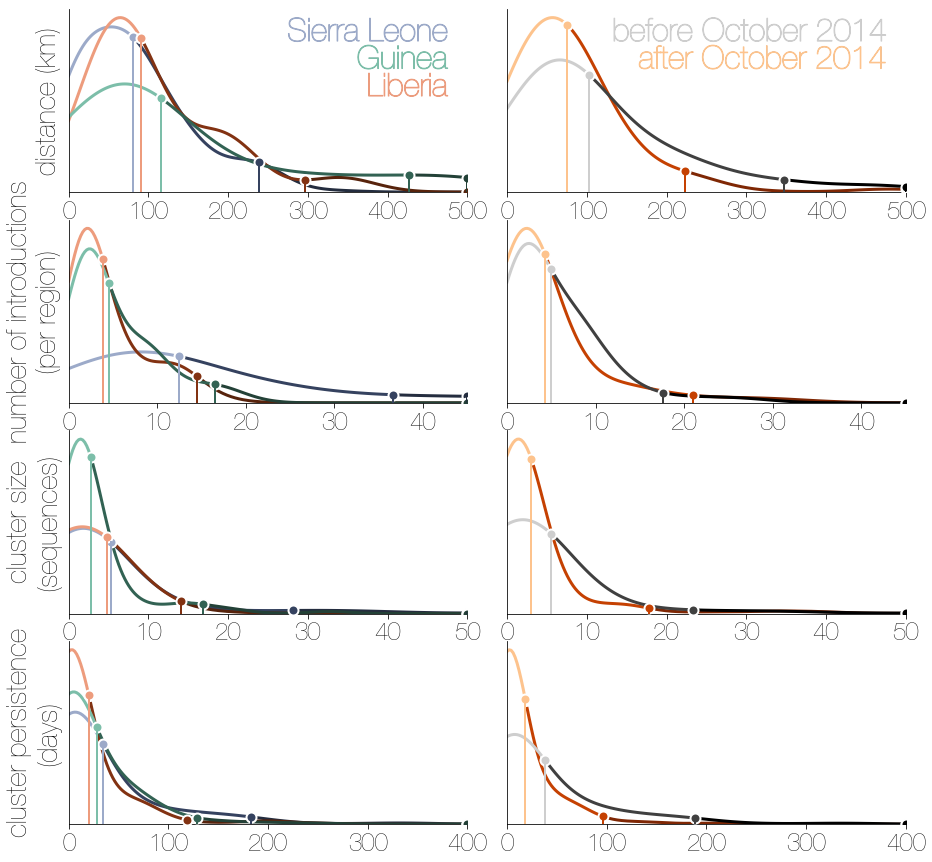

In [7]:
plt.figure(figsize=(15,15),facecolor='w')

gs = gridspec.GridSpec(len(stats),2,hspace=0.15,wspace=0.1) ## gridspec for figure grid

translate={'SLE':'Sierra Leone','LBR':'Liberia','GIN':'Guinea',
           'MLI':'Mali','SEN':'Senegal','GNB':'Guinea-Bissau','CIV':"Cote d'Ivoire"}

translate_stat={'dist':'distance (km)',
                'intro':'number of introductions\n(per region)',
                'leaves':'cluster size\n(sequences)',
                'pers':'cluster persistence\n(days)'}

for t in kernels.keys():
    for s in stats:
        ax = plt.subplot(gs[stats.index(s), kernels.keys().index(t)])
        
        if kernels.keys().index(t)==0:
            ax.set_ylabel(translate_stat[s],size=28)
        if stats.index(s)==len(stats)-1:
            pass
            #ax.set_xlabel('%s : %s'%(t,time_blocks[time_blocks.index(t)+1]))
        elif stats.index(s)==0:
            if kernels.keys().index(t)==0:
                
                for country in countries:
                    effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                         path_effects.Stroke(linewidth=1, foreground=colours[country](0.3))] ## black text, white outline
                    ax.text(0.95,0.95-0.15*countries.index(country),'%s'%(translate[country]),ha='right',va='top',transform=ax.transAxes,size=32,path_effects=effects)
            else:
                effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                         path_effects.Stroke(linewidth=1, foreground=mpl.cm.Greys(0.3))] ## black text, white outline
                ax.text(0.95,0.95,'before October 2014',ha='right',va='top',transform=ax.transAxes,size=32,path_effects=effects)
                
                effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                         path_effects.Stroke(linewidth=1, foreground=mpl.cm.Oranges(0.3))] ## black text, white outline
                ax.text(0.95,0.8,'after October 2014',ha='right',va='top',transform=ax.transAxes,size=32,path_effects=effects)
        
        
        highestY=0.0
        for c in kernels[t][s].keys():
            #print t,s,c,np.log10(len(raw_data[t][s][c]))
            
            data=densities[t][s][c]
            
            for integral in data:
                xs,ys=integral
                
                print c,s,xs[-1]
                
                al=0.5
                if c in countries:
                    col=colours[c](0.3+data.index(integral)/float(len(data)-1))
                elif c==time_blocks[0]:
                    col=mpl.cm.Greys(0.3+data.index(integral)/float(len(data)-1)) ## early
                elif c==time_blocks[1]:
                    col=mpl.cm.Oranges(0.3+data.index(integral)/float(len(data)-1)) ## late
                ax.plot(xs,ys,color=col,lw=3)
                ax.scatter(xs[-1],ys[-1],100,facecolor=col,edgecolor='w',lw=2,zorder=10)
                ax.plot([xs[-1],xs[-1]],[ys[-1],0],color=col,ls='-',lw=2,zorder=100)
                if max(ys)>highestY:
                    highestY=max(ys)
                
        ax.set_ylim(0,highestY*1.05)
                #ax.fill_between(xs,ys,facecolor=colours[c](1-data.index(integral)/float(len(data))),edgecolor='w',lw=1,alpha=al) ## plot pdf for each interval
        ax.set_xlim(min(grids[s]),max(grids[s]))
        
        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',size=5,labelsize=24,direction='out')
        ax.tick_params(axis='y',size=0)
        ax.set_yticklabels([])
        
# plt.savefig(local_output+'EBOV_multikernels.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_multikernels.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [8]:
xmin=decimalDate('2013-12-01') ## these will define the limits over which KDEs will be estimated
xmax=decimalDate('2015-10-01')
ymin=0
ymax=600

N=70 ## define the grain over which to infer KDEs (100x100 in this case)

to_plot={}

collect_all=[]
within_countries=[]
between_countries=[]

local_maximum=[]

for country in required_countries: ## iterate over countries
    print 'within %s done'%(country)
    
    times=column(within[country],1)
    distances=column(within[country],0)
    
    if len(times)==0 and len(distances)==0:
        to_plot['within_%s'%(country)]=[np.empty(5,),np.empty(5,),np.empty((5,5))]
    else:
        X_grid,Y_grid,Z_grid=kde_scipy(times,distances,(xmin,xmax),(ymin,ymax),N) 
        local_maximum.append(Z_grid.max())
        to_plot['within_%s'%(country)]=[X_grid,Y_grid,Z_grid]

    collect_all+=within[country]
    
    for country2 in required_countries: ## iterate over countries a second time, only do between country comparisons
        if country!=country2: ## calculate multivariate KDE from jumps occuring between countries
            print 'from %s to %s done'%(country,country2)
            times=column(between[country][country2],1)
            distances=column(between[country][country2],0)
            
            if len(times)==0 and len(distances)==0:
                to_plot['between_%s_%s'%(country,country2)]=[np.empty(5,),np.empty(5,),np.empty((5,5))]
            else: 
                X_grid,Y_grid,Z_grid=kde_scipy(times,distances,(xmin,xmax),(ymin,ymax),N)
                #print X_grid.shape,Y_grid.shape,Z_grid.shape
                local_maximum.append(Z_grid.max())
                to_plot['between_%s_%s'%(country,country2)]=[X_grid,Y_grid,Z_grid]
                
            collect_all+=between[country][country2]
            between_countries+=between[country][country2]
        else: ## calculate multivariate KDE from jumps occuring within the country
            within_countries+=within[country]

X_all,Y_all,Z_all=kde_scipy(column(collect_all,1),column(collect_all,0),(xmin,xmax),(ymin,ymax),N)
local_maximum.append(Z_all.max())
print 'All transitions done'
X_between,Y_between,Z_between=kde_scipy(column(between_countries,1),column(between_countries,0),(xmin,xmax),(ymin,ymax),N)
local_maximum.append(Z_between.max())

print 'Between transitions done'
X_within,Y_within,Z_within=kde_scipy(column(within_countries,1),column(within_countries,0),(xmin,xmax),(ymin,ymax),N)
local_maximum.append(Z_within.max())
print 'Within transitions done'

absolute_maximum=max(local_maximum)

normalize_KDEs=False

if normalize_KDEs==True:
    print 'Normalizing all KDEs by %.5f'%(absolute_maximum)

    ## iterate over countries
    for country in countries:
        X_grid,Y_grid,Z_grid=to_plot['within_%s'%(country)]
        Z_grid=Z_grid/absolute_maximum
        to_plot['within_%s'%(country)]=[X_grid,Y_grid,Z_grid]

        for country2 in countries:
            if country!=country2:
                X_grid,Y_grid,Z_grid=to_plot['between_%s_%s'%(country,country2)]
                Z_grid=Z_grid/absolute_maximum
                to_plot['between_%s_%s'%(country,country2)]=[X_grid,Y_grid,Z_grid]

    to_plot['all']=[X_all,Y_all,Z_all/absolute_maximum]
    to_plot['within']=[X_within,Y_within,Z_within/absolute_maximum]
    to_plot['between']=[X_between,Y_between,Z_between/absolute_maximum]
else:
    print 'NOTE - multivariate KDEs will be relative'
    to_plot['all']=[X_all,Y_all,Z_all]
    to_plot['within']=[X_within,Y_within,Z_within]
    to_plot['between']=[X_between,Y_between,Z_between]

within SLE done
from SLE to LBR done
from SLE to GIN done
within LBR done
from LBR to SLE done
from LBR to GIN done
within GIN done
from GIN to SLE done
from GIN to LBR done
All transitions done
Between transitions done
Within transitions done
NOTE - multivariate KDEs will be relative


within_SLE 0.0877101132601
between_SLE_LBR 0.521466914785
between_SLE_GIN 0.0661156831804
between_LBR_SLE 0.280714618063
within_LBR 0.0998659838999
between_LBR_GIN 0.0564615779066
between_GIN_SLE 0.153859024674
between_GIN_LBR 0.197245288116
within_GIN 0.0358042288923


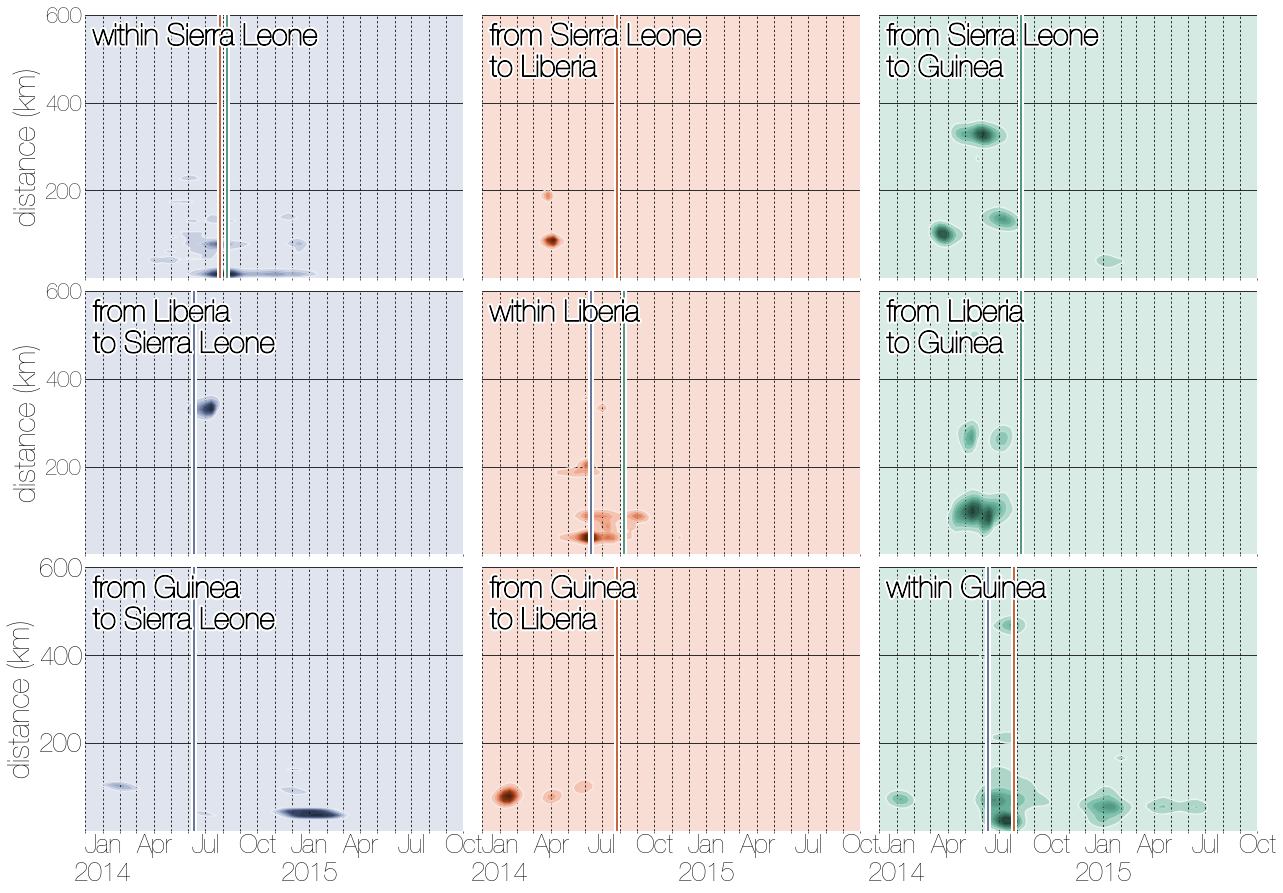

all 0.0401454022644


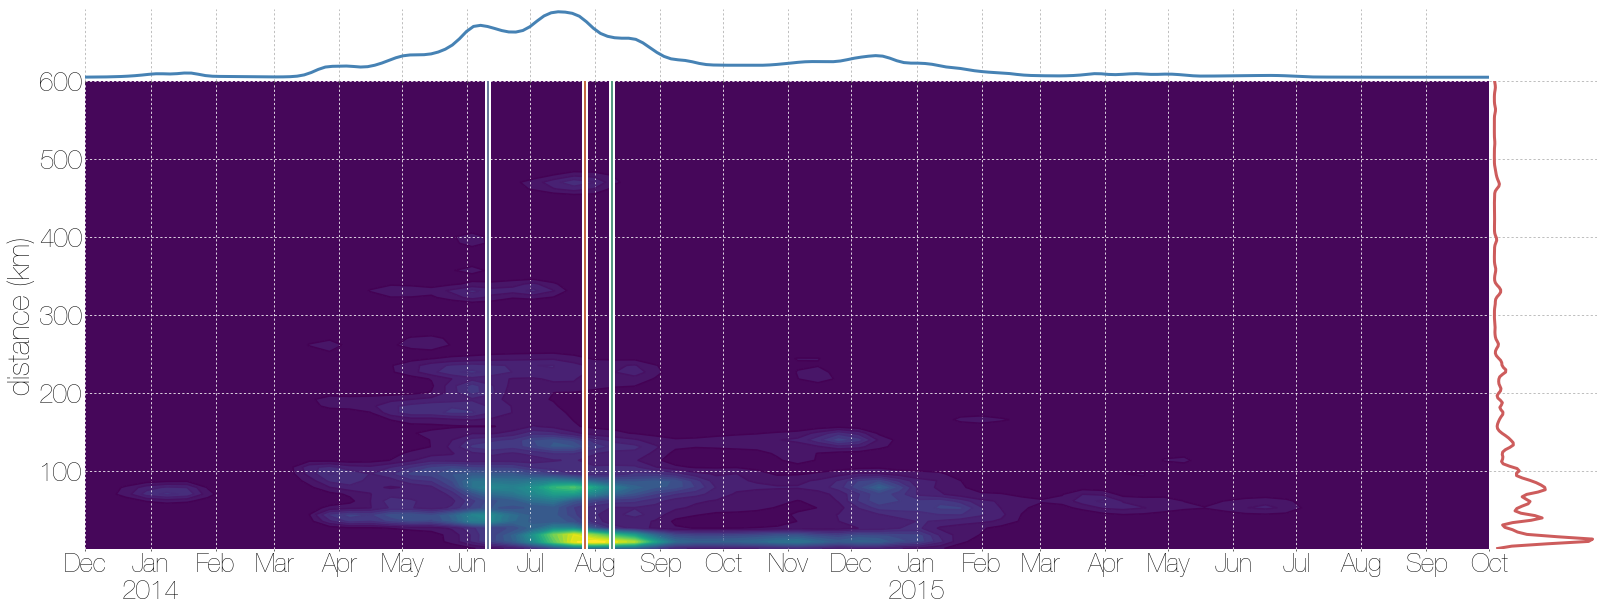

within 0.0449782940016


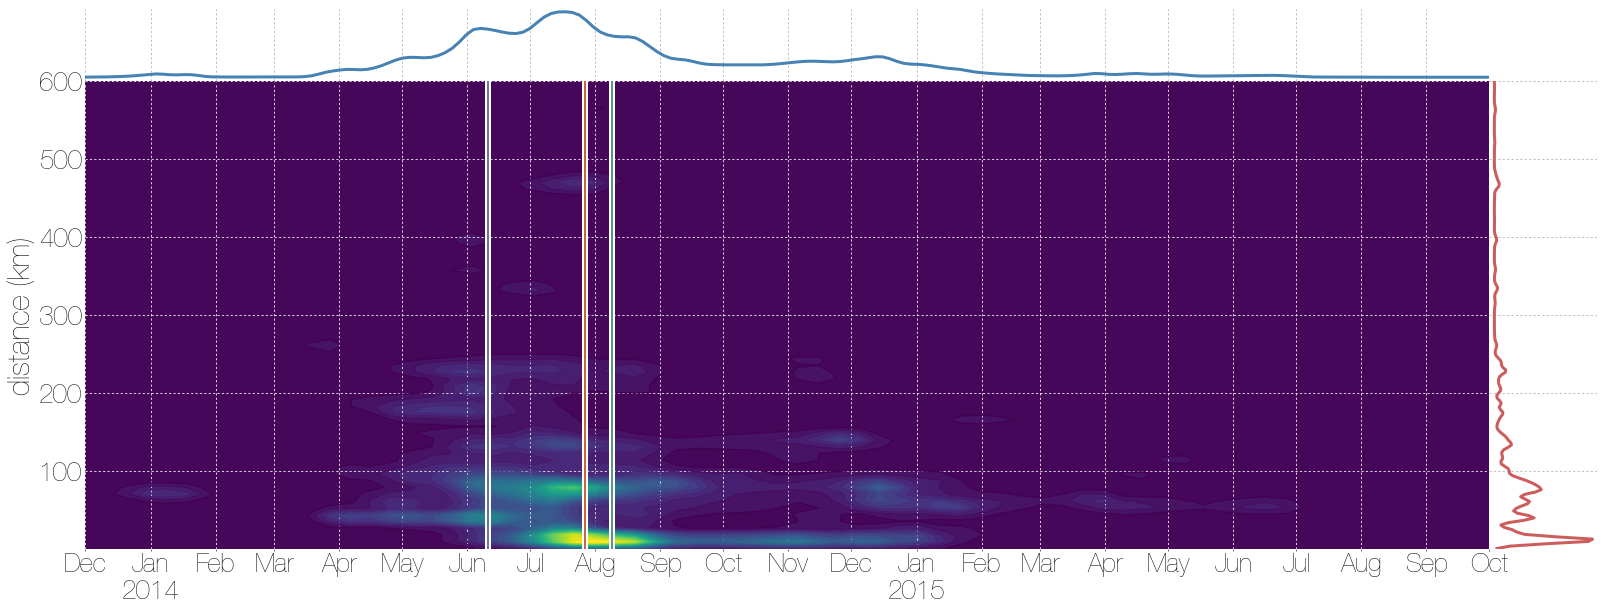

between 0.0372279676248


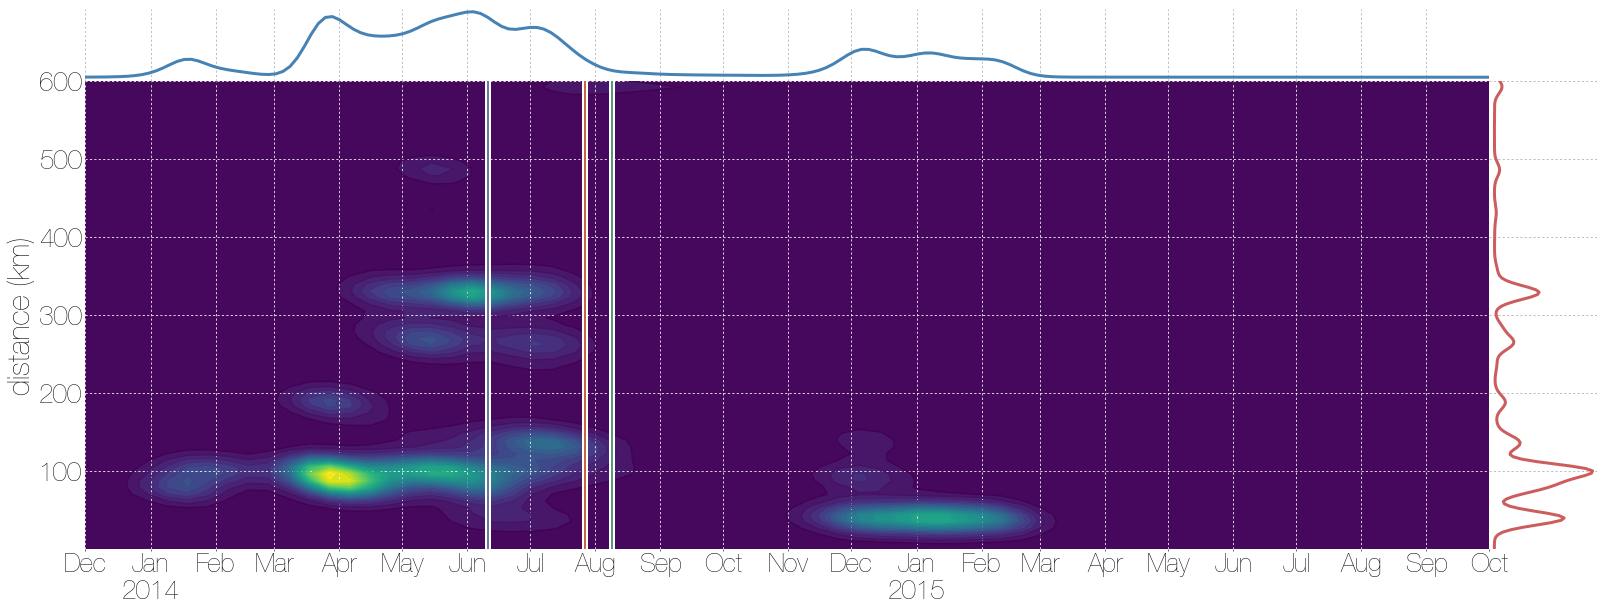

In [9]:
every=3
all_mons=['2013-%02d-01'%(x) for x in range(12,13,1)]
all_mons+=['2014-%02d-01'%(x) for x in range(1,13,1)]
all_mons+=['2015-%02d-01'%(x) for x in range(1,11,1)]

mons=[x for i,x in enumerate(all_mons) if (i+2)%every==0]

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'}

contours=10 ## number of contour intervals

fig = plt.figure(figsize=(len(required_countries)*7, len(required_countries)*5))
gs = gridspec.GridSpec(len(required_countries), len(required_countries),hspace=0.05,wspace=0.05)

## plot 3x3 grid of multivariate KDEs showing jumps within and between countries
for i,country1 in enumerate(required_countries): ## iterate over country combinations
    for j,country2 in enumerate(required_countries):
        
        if country1==country2: ## if country is same - display within country jumps
            kind='within_%s'%(country1)
            
        else: ## otherwise - display between country jumps
            kind='between_%s_%s'%(country1,country2)
        
        ax=plt.subplot(gs[len(required_countries)*i+j]) ## create subplot

        k=kind.split('_')

        if k[0]=='within': ## if within country
            country=k[1]
            cmap=colours[country]
            ax.text(0.02,0.97,'%s %s'%(k[0],translate[country]),size=30,va='top',ha='left',transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')])

            for other_country in required_countries:
                if other_country!=country:
                    ax.axvline(decimalDate(closure_dates[other_country]),lw=2,color=colours[other_country](0.5),zorder=3)
                    ax.axvline(decimalDate(closure_dates[other_country]),lw=6,color='w',zorder=2)
            
        elif len(k)>2: ## if between countries
            origin,destination=k[1:]
            cmap=colours[destination]
                    
            ax.text(0.02,0.97,'from %s\nto %s'%(translate[origin],translate[destination]),size=30,va='top',ha='left',transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')])
            
            ax.axvline(decimalDate(closure_dates[destination]),lw=2,color=colours[destination](0.5),zorder=3)
            ax.axvline(decimalDate(closure_dates[destination]),lw=6,color='w',zorder=2)
            
        else: ## all transitions
            ax.grid(ls='--',color='w')
            cmap=mpl.cm.get_cmap('viridis')
            ax.text(0.02,0.97,'all transitions',size=30,va='top',ha='left',transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')])
            
        X_grid,Y_grid,Z_grid=to_plot[kind] ## fetch KDE data
        if X_grid[0]>0:
            print kind,Z_grid.max()

            
            ax.contourf(X_grid,Y_grid,Z_grid,contours,cmap=cmap) ## plot KDEs
            ax.contour(X_grid,Y_grid,Z_grid,contours,cmap=cmap,lw=0.1)

        ax.set_xticks([decimalDate(x) for x in mons]) ## set tick labels
        ax.set_xticks([decimalDate(x) for x in all_mons],minor=True)

        ax.grid(color='k',axis='y') ## add grid
        ax.grid(ls=':',color='k',which='minor')
        
        ax.set_ylim(ymin,ymax) ## set axis limits
        ax.set_xlim(xmin,xmax)
        
        plt.draw()
        
        if j==0: ## remove tick labels and add axis labels, depending on subplot position
            ax.set_ylabel('distance (km)',size=30)
            ax.set_yticklabels([str(y.get_text()) if str(y.get_text())!='0' else '' for y in ax.get_yticklabels()])
        else:
            ax.set_yticklabels([])
            
        if i==len(required_countries)-1:
            ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in mons])
            ax.tick_params(labelsize=26,size=0)
        else:
            ax.set_xticklabels([])
            ax.tick_params(axis='x',size=0)
        
        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        ax.tick_params(size=0)
        ax.spines['top'].set_visible(False) ## remove borders
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

# plt.savefig(local_output+'EBOV_KDE2d_countries.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_KDE2d_countries.pdf',dpi=300,bbox_inches='tight')

plt.show()

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width

rect_2d = [left, bottom, width, height]
rect_time = [left, bottom_h, width, 0.1]
rect_distance = [left_h, bottom, 0.05, height]

for migration_class in ['all','within','between']: ## plot the same thing but for all of West Africa
    plt.figure(1, figsize=(30, 10))

    ax2d = plt.axes(rect_2d)
    axT = plt.axes(rect_time)
    axD = plt.axes(rect_distance)

    if migration_class=='within': ## perform 1D KDEs along an axis
        kernel_time = gaussian_kde(column(within_countries,0))
        kernel_distance = gaussian_kde(column(within_countries,1))
    elif migration_class=='between':
        kernel_time = gaussian_kde(column(between_countries,0))
        kernel_distance = gaussian_kde(column(between_countries,1))
    elif migration_class=='all':
        kernel_time = gaussian_kde(column(collect_all,0))
        kernel_distance = gaussian_kde(column(collect_all,1))

    
    time_grid=np.linspace(xmin,xmax,200) ## time axis
    distance_grid=np.linspace(ymin,ymax,200) ## distance axis

    axT.plot(time_grid,[kernel_time(t) for t in time_grid],lw=3,color='steelblue') ## plot KDEs
    axD.plot([kernel_distance(d) for d in distance_grid],distance_grid,lw=3,color='indianred')

    axT.set_xlim(xmin,xmax)
    axD.set_ylim(ymin,ymax)

    axT.tick_params(size=0)
    axD.tick_params(size=0)
    axT.set_xticklabels([])
    axT.set_yticklabels([])
    axD.set_xticklabels([])
    axD.set_yticklabels([])
    
    axT.grid(axis='x',ls=':')
    axD.grid(axis='y',ls=':')

    axT.set_xticks([decimalDate(x) for x in all_mons])
    axT.set_xticks([decimalDate(x) for x in all_mons],minor=True)

    plt.draw()

    axT.set_xticklabels(['' for x in all_mons])

    axT.spines['top'].set_visible(False)
    axT.spines['right'].set_visible(False)
    axT.spines['left'].set_visible(False)
    axT.spines['bottom'].set_visible(False)

    axD.spines['top'].set_visible(False)
    axD.spines['right'].set_visible(False)
    axD.spines['left'].set_visible(False)
    axD.spines['bottom'].set_visible(False)

    X_grid,Y_grid,Z_grid=to_plot[migration_class] ## plot main 2D KDE

    print migration_class,Z_grid.max()
    
    cmap=mpl.cm.get_cmap('viridis')
    ax2d.contourf(X_grid,Y_grid,Z_grid,contours+20,cmap=cmap)
    ax2d.contour(X_grid,Y_grid,Z_grid,contours+20,cmap=cmap,lw=0.1)
    
    for country in required_countries: ## add border closures
        ax2d.axvline(decimalDate(closure_dates[country]),lw=2,color=colours[country](0.5),zorder=3)
        ax2d.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)
    
    ax2d.tick_params(labelsize=26,size=0)

    ax2d.spines['top'].set_visible(False)
    ax2d.spines['right'].set_visible(False)
    ax2d.spines['left'].set_visible(False)
    ax2d.spines['bottom'].set_visible(False)

    ax2d.set_xticks([decimalDate(x) for x in all_mons])
    ax2d.set_xticks([decimalDate(x) for x in all_mons],minor=True)

    ax2d.set_ylim(ymin,ymax)
    ax2d.set_xlim(xmin,xmax)

    plt.draw()

    ax2d.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in all_mons])

    ax2d.grid(color='w',axis='y')
    ax2d.grid(ls=':',color='w')

    ax2d.set_ylabel('distance (km)',size=30)
    ax2d.set_yticklabels([str(y.get_text()) if str(y.get_text())!='0' else '' for y in ax2d.get_yticklabels()])

#     plt.savefig(local_output+'EBOV_KDE2d_%s.png'%(migration_class),dpi=300,bbox_inches='tight')
#     plt.savefig(local_output+'EBOV_KDE2d_%s.pdf'%(migration_class),dpi=300,bbox_inches='tight')
    plt.show()

In [10]:
xmin=decimalDate('2013-12-01') ## these will define the limits over which KDEs will be estimated
xmax=decimalDate('2015-10-01')

N=70 ## define the grain over which to infer KDEs

to_plot_1D={}

collect_all_1D=[]
within_countries_1D=[]
between_countries_1D=[]

local_maximum_1D=[]

x_grid=np.linspace(xmin,xmax,N)

for country in required_countries: ## iterate over countries
    
    print 'within %s done'%(country)
    times=column(within[country],0)
    
    if len(times)>0:
        kernel=gaussian_kde(times) ## calculate univariate KDE from jumps occuring within the country
        y_grid=kernel(x_grid)
        to_plot_1D['within_%s'%(country)]=[x_grid,y_grid]
        local_maximum_1D.append(y_grid.max())
        collect_all_1D+=within[country]
        within_countries_1D+=within[country]
    else:
        to_plot_1D['within_%s'%(country)]=[np.empty(1),np.empty(1)]

    
    for country2 in required_countries:
        if country!=country2: ## iterate over countries a second time, only do between country comparisons
            print 'from %s to %s done'%(country,country2)
            times=column(between[country][country2],0)
            
            if len(times)>0:
                kernel=gaussian_kde(times)
                y_grid=kernel(x_grid)
                local_maximum_1D.append(y_grid.max())
                to_plot_1D['between_%s_%s'%(country,country2)]=[x_grid,y_grid]
                collect_all_1D+=between[country][country2]
                between_countries_1D+=between[country][country2]
            else:
                to_plot_1D['between_%s_%s'%(country,country2)]=[np.empty(1),np.empty(1)]

print local_maximum_1D
            
kernel=gaussian_kde(column(collect_all_1D,0))
y_all=kernel(x_grid)
local_maximum_1D.append(y_all.max())
print 'All transitions done'

kernel=gaussian_kde(column(between_countries_1D,0))
y_between=kernel(x_grid)
local_maximum_1D.append(y_between.max())
print 'Between transitions done'

kernel=gaussian_kde(column(within_countries_1D,0))
y_within=kernel(x_grid)
local_maximum_1D.append(y_within.max())
print 'Within transitions done'

absolute_maximum_1D=max(local_maximum_1D)

normalize_KDEs_1D=True

if normalize_KDEs_1D==True:
    print 'Normalizing all KDEs by %.5f'%(absolute_maximum_1D)
    
    ymax=int(absolute_maximum_1D+1)
    
#     ## iterate over countries
#     for country in countries:
#         X_grid,Y_grid=to_plot_1D['within_%s'%(country)]
#         Y_grid=Y_grid/absolute_maximum_1D
#         to_plot_1D['within_%s'%(country)]=[X_grid,Y_grid]

#         for country2 in countries:
#             if country!=country2:
#                 X_grid,Y_grid=to_plot_1D['between_%s_%s'%(country,country2)]
#                 Y_grid=Y_grid/absolute_maximum_1D
#                 to_plot_1D['between_%s_%s'%(country,country2)]=[X_grid,Y_grid]

#     to_plot_1D['all']=[x_grid,y_all/absolute_maximum_1D]
#     to_plot_1D['within']=[x_grid,y_within/absolute_maximum_1D]
#     to_plot_1D['between']=[x_grid,y_between/absolute_maximum_1D]
else:
    print 'NOTE - multivariate KDEs will be relative'
    to_plot_1D['all']=[x_grid,y_all]
    to_plot_1D['within']=[x_grid,y_within]
    to_plot_1D['between']=[x_grid,y_between]

within SLE done
from SLE to LBR done
from SLE to GIN done
within LBR done
from LBR to SLE done
from LBR to GIN done
within GIN done
from GIN to SLE done
from GIN to LBR done
[2.8841605430652573, 13.891141720158425, 4.2842707601159269, 5.6056421324635828, 10.814565905339986, 6.1880321441440707, 3.2116411823324889, 3.5199177572163829, 9.2618746219799739]
All transitions done
Between transitions done
Within transitions done
Normalizing all KDEs by 13.89114


within_SLE
within_SLE 2.88416054307
between_SLE_LBR
between_SLE_LBR 13.8911417202
between_SLE_GIN
between_SLE_GIN 4.28427076012
between_LBR_SLE
between_LBR_SLE 10.8145659053
within_LBR
within_LBR 5.60564213246
between_LBR_GIN
between_LBR_GIN 6.18803214414
between_GIN_SLE
between_GIN_SLE 3.51991775722
between_GIN_LBR
between_GIN_LBR 9.26187462198
within_GIN
within_GIN 3.21164118233


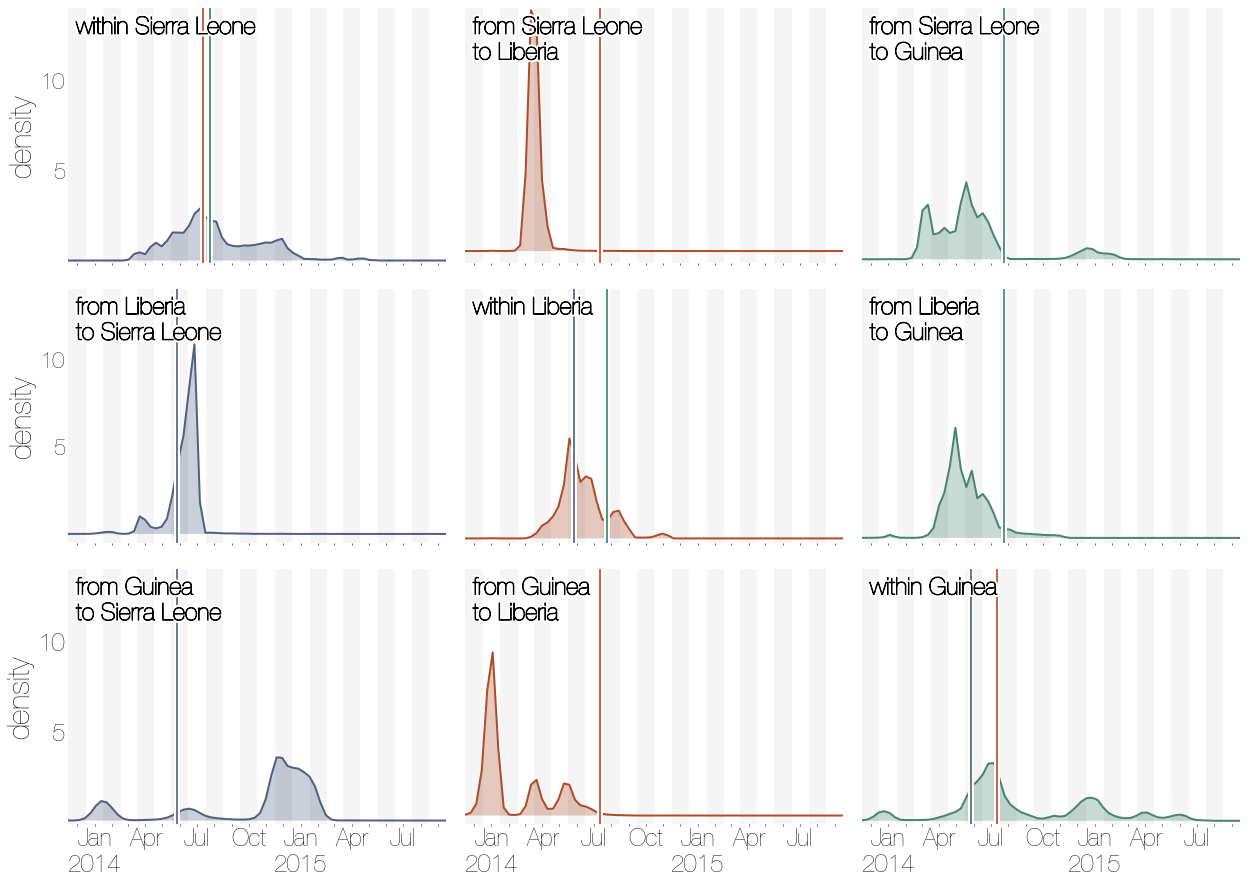

In [11]:
every=3
all_mons=['2013-%02d-01'%(x) for x in range(12,13,1)]
all_mons+=['2014-%02d-01'%(x) for x in range(1,13,1)]
all_mons+=['2015-%02d-01'%(x) for x in range(1,11,1)]

mons=[x for i,x in enumerate(all_mons) if (i+2)%every==0]

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'}

fig = plt.figure(figsize=(len(required_countries)*7, len(required_countries)*5))
gs = gridspec.GridSpec(len(required_countries), len(required_countries),hspace=0.1,wspace=0.05)

## plot 3x3 grid of multivariate KDEs showing jumps within and between countries
for i,country1 in enumerate(required_countries):
    for j,country2 in enumerate(required_countries): ## iterate over country combinations
        
        if country1==country2: ## if country is same - display within country jump densities
            kind='within_%s'%(country1)
        else: ## otherwise - display between country jump densities
            kind='between_%s_%s'%(country1,country2)

        ax=plt.subplot(gs[len(required_countries)*i+j]) ## create subplot

        print kind
        k=kind.split('_')
        
        if k[0]=='within': ## if within country
            country=k[1]
            cmap=colours[country]
            ax.text(0.02,0.97,'%s %s'%(k[0],translate[country]),size=24,va='top',ha='left',transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')],zorder=10)
            
            for other_country in required_countries:
                if other_country!=country:
                    ax.axvline(decimalDate(closure_dates[other_country]),lw=2,color=colours[other_country](0.5),zorder=6)
                    ax.axvline(decimalDate(closure_dates[other_country]),lw=6,color='w',zorder=5)
            
        elif len(k)>2: ## if between countries
            origin,destination=k[1:]
            cmap=colours[destination]
            
            ax.text(0.02,0.97,'from %s\nto %s'%(translate[origin],translate[destination]),size=24,va='top',ha='left',transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')],zorder=10)
        
            ax.axvline(decimalDate(closure_dates[destination]),lw=2,color=colours[destination](0.5),zorder=6)
            ax.axvline(decimalDate(closure_dates[destination]),lw=6,color='w',zorder=5)

        else: ## all transitions
            ax.grid(ls='--',color='w')
            cmap=mpl.cm.get_cmap('viridis')
            ax.text(0.02,0.97,'all transitions',size=30,va='top',ha='left',transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')],zorder=10)

        X_grid,Y_grid=to_plot_1D[kind] ## fetch KDE data
        
        print kind,Y_grid.max()
        
        ## plot KDEs
        ax.plot(X_grid,Y_grid,color=cmap(0.6),lw=2,zorder=1)
        ax.fill_between(X_grid,Y_grid,facecolor=cmap(0.6),edgecolor='none',alpha=0.3,zorder=0)
        
        ax.set_xticks([decimalDate(x)+1/24.0 for x in mons]) ## set tick labels
        ax.set_xticks([decimalDate(x)+1/24.0 for x in all_mons],minor=True)
        
        ax.xaxis.tick_bottom()
    
        ax.set_ylim(top=ymax) ## set axis limits
        ax.set_xlim(xmin,xmax)
        
        plt.draw()
        
        if j==0: ## remove tick labels and add axis labels, depending on subplot position
            ax.set_ylabel('density',size=30)
            ax.set_yticklabels([str(y.get_text()) if str(y.get_text())!='0' else '' for y in ax.get_yticklabels()])
        else:
            ax.set_yticklabels([])
            
        if i==len(required_countries)-1:
            ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in mons])

            ax.tick_params(labelsize=24,size=0)
        else:
            ax.set_xticklabels([])
            ax.tick_params(axis='x',size=0)
        
        ax.tick_params(size=0)
        ax.spines['top'].set_visible(False) ## remove borders
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        [ax.axvspan(decimalDate(all_mons[x]),decimalDate(all_mons[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(all_mons),2)]
        
# plt.savefig(local_output+'EBOV_KDE1d_countries_absolute.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_KDE1d_countries_absolute.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [12]:
x_grid=np.linspace(0.0,1000.0,1001)
kde=gaussian_kde(all_distances,bw_method=0.5) ## estimate kernel from all jump distances

y_grid=kde.evaluate(x_grid)
print len(all_distances)

asymptote=kde.integrate_box_1d(0.0,max(x_grid)) ## due to high bandwidth of KDE it's necessary to renormalize the integral to be between 0.0 and 1.0
integral=[kde.integrate_box_1d(0.0,x)/asymptote for x in np.linspace(0.0,1000.0,1001)] ## get normalized integral

8045996


50%: 91.00 95%: 333.00


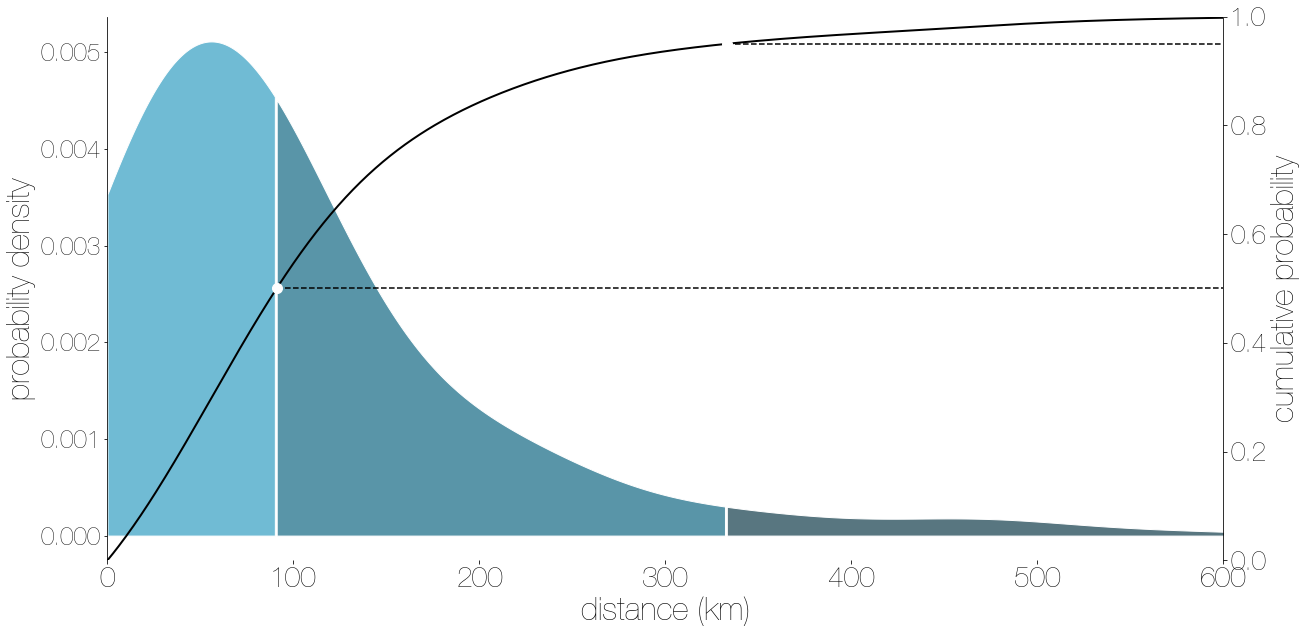

In [16]:
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

ax2=ax.twinx()

X_grid=np.linspace(min(x_grid),max(x_grid),len(integral))
ax2.plot(X_grid,integral,lw=2,color='k',ls='-') ## plot cumulative probability

closestTo50=sorted(integral,key=lambda x:abs(x-0.5))[0] ## identify slice closest to 0.5
idx50=integral.index(closestTo50)

closestTo95=sorted(integral,key=lambda x:abs(x-0.95))[0] ## identify slice closest to 0.95
idx95=integral.index(closestTo95)

print '50%%: %.2f 95%%: %.2f'%(x_grid[idx50],x_grid[idx95]) ## report

al=0.5
ax.fill_between(x_grid[:idx50],y_grid[:idx50],facecolor='#70BBD4',edgecolor='w',lw=1) ## plot pdf for each interval
ax.fill_between(x_grid[idx50:idx95],y_grid[idx50:idx95],facecolor='#5995A8',edgecolor='w',lw=1)
ax.fill_between(x_grid[idx95:],y_grid[idx95:],facecolor='#587680',edgecolor='w',lw=1)

ax2.plot([x_grid[idx50],max(x_grid)],[integral[idx50],integral[idx50]],ls='--',color='k')
ax2.plot([x_grid[idx95],max(x_grid)],[integral[idx95],integral[idx95]],ls='--',color='k')

ax2.scatter(x_grid[idx95],integral[idx95],s=100,zorder=3,facecolor='w')
ax2.scatter(x_grid[idx50],integral[idx50],s=100,zorder=3,facecolor='w')
#ax.plot([x_grid[idx50],x_grid[idx50]],[0.0,y_grid[idx50]],zorder=1)
#ax.fill_between(x_grid[:idx50],y_grid[:idx50],alpha=al,facecolor='grey',edgecolor='k',zorder=1)
#ax.fill_between(x_grid[:idx95],y_grid[:idx95],alpha=al,facecolor='grey',edgecolor='k',zorder=0)

ax.tick_params(axis='x',labelsize=28,direction='out')
ax.tick_params(axis='y',labelsize=24,direction='out')
ax2.tick_params(axis='y',labelsize=26,direction='out')
ax.yaxis.tick_left()
ax2.yaxis.tick_right()

ax.xaxis.tick_bottom()
ax2.xaxis.tick_bottom()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax.set_xlabel('distance (km)',size=32)
ax.set_ylabel('probability density',size=32)
ax2.set_ylabel('cumulative probability',size=32)
ax2.set_ylim(0.0,1.0)
ax.set_xlim(0,600)

# plt.savefig(local_output+'EBOV_kernel.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_kernel.pdf',dpi=300,bbox_inches='tight')

plt.show()